In [1]:
from src.tools import group, xy, read, hough, parseData
from matplotlib import pyplot as plt
from src.img import getBrightest, np
import math as M
import cv2 as C

file, sz, Y_AXIS, BEAD_FREQ, CT, BBOX, BEAD_SIZE, IBD = parseData('data.txt')
(y0, x0, y1, x1) = BBOX

circle_mode = True
B_POS = (Y_AXIS, y0)
B_SIZ = 15

REF = C.resize(read('frame.png'), (sz[0], sz[1]), interpolation=C.INTER_AREA)

[range(9, 11), range(35, 39)]
{9: 71, 38: 90}


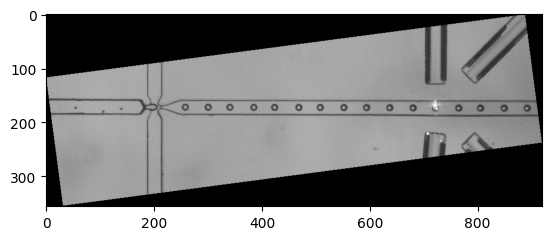

In [2]:
lums = []
cache = {}

for i in range(1, CT - 1):
  name = f'{i:03d}'
  img = read(f'./out_dir/{name}.png')

  lum = np.sum(img > 200)
  lums.append(lum)
  cache[name] = lum
mean, std = np.mean(lums), np.std(lums)

# delete items in cache that are not in lums
for k in list(cache.keys()):
  if cache[k] < mean + std:
    del cache[k]

ranges = group(list(map(int, cache.keys())))
maxes = {}
for r in ranges:
  argmax = max(r, key=lambda k: cache[f"{k:03d}"])
  maxes[argmax] = cache[f"{argmax:03d}"]

print(ranges)
print(maxes)

img = read(f'./in_dir/{max(maxes, key=maxes.get):03d}.png')
plt.imshow(img, cmap='gray')
plt.show()

Using frame 33


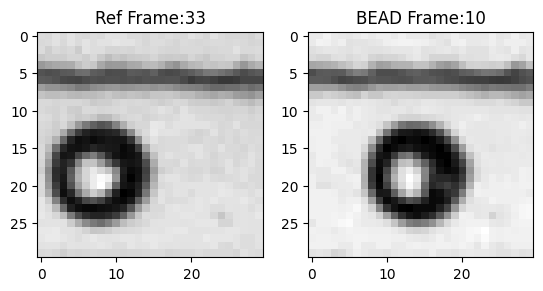

In [6]:
REV = round(1 * BEAD_FREQ * BEAD_SIZE /(IBD + 2*BEAD_SIZE))
bead = max([max(maxes, key=lambda k: maxes[k]) - REV, 1])
print(f"Using frame {bead}")

img_ref = read(f'./in_dir/{bead:03d}.png')
x0, y0, x1, y1 = xy((B_POS[0], round(B_POS[1] - sz[0])), B_SIZ)
img_bead = img_ref[x0:x1, y0:y1]


base = bead - BEAD_FREQ if BEAD_FREQ < bead else bead + BEAD_FREQ
img_ref = read(f'./in_dir/{base:03d}.png')
x0, y0, x1, y1 = xy((B_POS[0], round(B_POS[1] - sz[0])), B_SIZ)
img_base = img_ref[x0:x1, y0:y1]

fig, axs = plt.subplots(1, 2)
axs[0].imshow(img_bead, cmap='gray')
axs[0].set_title(f"Ref Frame:{bead}")
axs[1].imshow(img_base, cmap='gray')
axs[1].set_title(f"BEAD Frame:{base}")
plt.show()

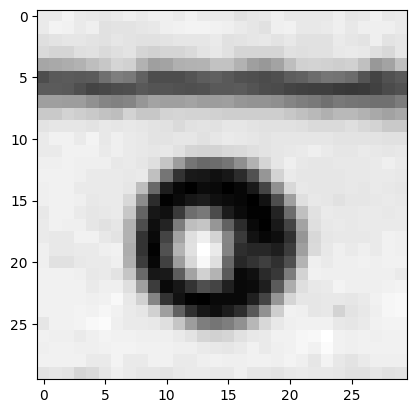

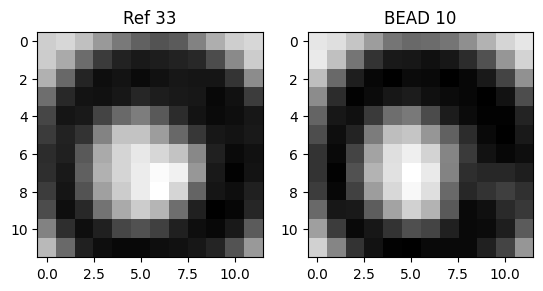

In [13]:
dy, dx = REF.shape
r = round((REF.shape[0] / 2) + 1)

if circle_mode:
  # via HoughCircles
  x0, y0, _ = hough(img_bead, minDist=1, param1=150, param2=10, minRadius=1, maxRadius=dx)[0][0]
  img_bead2 = img_bead[y0-r:y0+r, x0-r:x0+r].copy()

  x1, y1, _ = hough(img_base, minDist=1, param1=150, param2=10, minRadius=1, maxRadius=dx)[0][0]
  img_base2 = img_base[y1-r:y1+r, x1-r:x1+r].copy()

else:
  res = C.minMaxLoc(C.matchTemplate(REF, img_bead, C.TM_CCOEFF_NORMED))
  min_val, max_val, (x0, y0), (x1, y1) = res
  img_bead2 = img_bead[x1-dx:x1, y1-dy:y1].copy()

  res = C.minMaxLoc(C.matchTemplate(REF, img_base, C.TM_CCOEFF_NORMED))
  min_val, max_val, (x0, y0), (x1, y1) = res
  img_base2 = img_base[x1-dx:x1, y1-dy:y1].copy()

fig, axs = plt.subplots(1, 2)
axs[0].imshow(img_bead2, cmap='gray')
axs[0].set_title(f"Ref {bead}")
# axs[1].imshow(img_base2, cmap='gray')
axs[1].imshow(img_base2, cmap='gray')
axs[1].set_title(f"BEAD {base}")
plt.show()

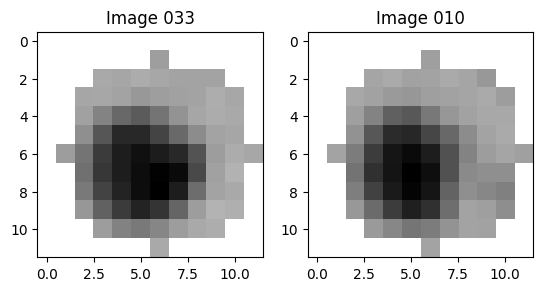

In [15]:
img_bead2 = 255 - img_bead2
img_base2 = 255 - img_base2

dx, dy = img_bead2.shape

cx, cy = round(dx/2), round(dy/2)
radius = round(min(dx, dy)*0.9/2)
mask = C.circle(np.zeros((dx, dy)), (cx, cy), radius, 1, -1)

img_bead2 = 255 - img_bead2 * mask
img_base2 = 255 - img_base2 * mask
fig, axs = plt.subplots(1, 2)
axs[0].imshow(img_bead2, cmap='gray')
axs[0].set_title(f"Image {bead:03d}")
axs[1].imshow(img_base2, cmap='gray')
axs[1].set_title(f"Image {base:03d}")
plt.show()

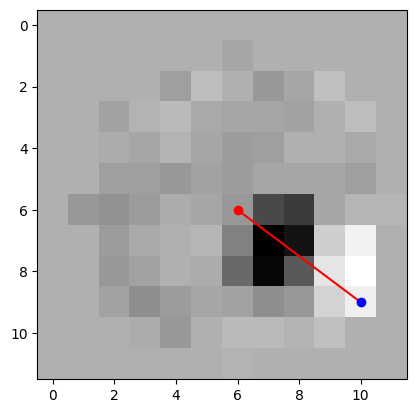

On circ of R = 5.0, D = 11.12
(cx, cy) = (6, 6), bead(x, y) = (10, 9)

|5px | 11.1R | 5.0px | 216.9° |


In [16]:
DARK = False

diff = img_base2 - img_bead2
if not DARK:
  diff = 255 - diff

mdp = getBrightest(3, diff)
bx, by = mdp

cx, cy = round(img_base2.shape[0] / 2), round(img_base2.shape[1] / 2)
plt.imshow(diff, cmap='gray')
plt.plot([cy, mdp[1]], [cx, mdp[0]], 'r')

plt.plot(cx, cy, 'ro')
plt.plot(mdp[1], mdp[0], 'bo')
plt.show()

D = M.sqrt((cx - mdp[0])**2 + (cy - mdp[1])**2)
theta = M.atan2(cx - bx, by - cy) * 180 / M.pi
theta = 180 - theta
print(f"On circ of R = {BEAD_SIZE}, D = {IBD}")
# I did all calc with the axes swapped
print(f"(cx, cy) = ({cy}, {cx}), bead(x, y) = {(by, bx)}")

print(f"\n|{BEAD_SIZE:.0f}px | {IBD:.1f}R | {D:.1f}px | {theta:.1f}° |")